In [2]:
#pip install bson


In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime


In [2]:
os.getcwd()

'D:\\Fall 2023\\6748 Practicum\\GT_MSA_LBA'

In [3]:
data_path = "../raw_data/NCAAM1 22_23"

In [4]:
def read_data(file_name):
    dataframe = pd.read_pickle(os.path.join(data_path,file_name))
    print(f"{file_name}:")
    return dataframe

In [5]:
file_names = os.listdir(data_path)
print(file_names)

['NCAAM1 22_23 gamesdf.pickle', 'NCAAM1 22_23 playerdictionary.pickle', 'NCAAM1 22_23 segment data.pickle', 'NCAAM1 22_23 segment player block and usage data.pickle', 'NCAAM1 22_23 shotsdf.pickle', 'NCAAM1 22_23 teamsdf.pickle']


In [6]:
games_df = read_data(file_names[0])
players_df = read_data(file_names[1])
segments_df = pd.DataFrame(read_data(file_names[2]))
segments_players_usage_blocking_df = pd.DataFrame(read_data(file_names[3]))
shots_df = pd.DataFrame(read_data(file_names[4]))
teams_df = read_data(file_names[5])


NCAAM1 22_23 gamesdf.pickle:
NCAAM1 22_23 playerdictionary.pickle:
NCAAM1 22_23 segment data.pickle:
NCAAM1 22_23 segment player block and usage data.pickle:
NCAAM1 22_23 shotsdf.pickle:
NCAAM1 22_23 teamsdf.pickle:


## Cleaning Shots DataFrame

In [7]:
#Remove rows with no player_id
shots_df = shots_df[shots_df.player_id!=False]

In [8]:
#Remove all the corner 3s that are registered as 2s
shots_df = shots_df[~(((shots_df.Zone==' 4-1')&(shots_df.x_coordinate<=3))|((shots_df.Zone==' 4-3')&(shots_df.x_coordinate>=47)))]

In [9]:
#Remove all the above the break 3s that are registered as 2s
shots_df = shots_df[~(((shots_df.Zone==' 4-1')|(shots_df.Zone==' 4-3')|(shots_df.Zone==' 4-2'))&(shots_df.Distance>=22.1458))]

In [10]:
#Remove all the 2s that are registered as above the break 3s
shots_df = shots_df[~(((shots_df.Zone==' 6-1')|(shots_df.Zone==' 6-3')|(shots_df.Zone==' 6-2'))&(shots_df.Distance<22.1458))]

In [11]:
#Remove all the 2s that are registered as corner 3s
shots_df = shots_df[~(((shots_df.Zone==' 5-1')&(shots_df.x_coordinate>3))|((shots_df.Zone==' 5-2')&(shots_df.x_coordinate<47)&(shots_df.x_coordinate>3)))]

In [12]:
#Reclassify the misclassified corner 3s (left instead of right corner)
shots_df.loc[((shots_df.Zone==' 5-2')&(shots_df.x_coordinate<=3)), 'Zone'] = ' 5-1'

In [13]:
shots_df.shape

(698299, 36)

# Feature: Time Remaining on Game Clock, Score Difference, Clutch Time

In [14]:
shots_df.dtypes

game_id           object
team_id           object
season_id         object
player_id         object
shot_id           object
score              int64
score_opp          int64
Period             int64
segment_id        object
Time              object
Time_Seconds       int64
Stat              object
Zone              object
x_coordinate     float64
y_coordinate     float64
Angle            float64
Distance         float64
Jumpshot            bool
Assisted            bool
Red Zone            bool
Floater             bool
Second Chance       bool
Layup               bool
Paint               bool
Drive               bool
Blocked             bool
ATO                 bool
Off Turnover        bool
Off Steal           bool
Hook Shot           bool
Fastbreak           bool
Pullup              bool
And1                bool
Turnaround          bool
Dunk                bool
Step Back           bool
dtype: object

In [15]:
shots_df["time_seconds"] = shots_df["Time_Seconds"]
shots_df["time_converted"] = shots_df["Time"].apply(lambda x: datetime.time(minute=int(x.split(":")[0]),second=int(x.split(":")[1]))) 
shots_df["score_difference"] = shots_df.score - shots_df.score_opp
shots_df["clutch_time"] = np.where((shots_df.Time_Seconds<=120) & (abs(shots_df.score-shots_df.score_opp)<5 & (shots_df.Period>=2)),1,0)


In [18]:
feature_list_1_shot_level = shots_df[["shot_id","time_seconds","score_difference","clutch_time"]]
feature_list_1_shot_level

,shot_id,time_seconds,score_difference,clutch_time
0,636a5fa6531336e79c3425dd,1130,1,0
1,636a5fa6531336e79c3425e1,1091,1,0
2,636a5fa6531336e79c3425e3,1086,1,0
3,636a5fa6531336e79c3425e8,1027,-1,0
4,636a5fa6531336e79c3425ea,988,-1,0
...,...,...,...,...
699561,648b3a7b98debb5769861cdd,91,-2,0
699562,648b3a7b98debb5769861ce0,37,-4,0
699563,648b3a7b98debb5769861ce2,35,-2,0
699564,648b3a7b98debb5769861ce4,11,-3,0


## Inspection to check if total uses match total posessions
## Create game segment mapper

In [19]:
game_segment_map_df = segments_df[["game_id","segment_id"]]
game_segment_map_df

,game_id,segment_id
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b5
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b6
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b7
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b8
...,...,...
203715,648b3a9e98debb5769861e35,648b3a0b98debb576986198a
203716,648b3a9e98debb5769861e35,648b3a0b98debb576986198b
203717,648b3a9e98debb5769861e35,648b3a0b98debb576986198c
203718,648b3a9e98debb5769861e35,648b3a0b98debb576986198d


In [20]:
game_totals = segments_df.groupby("game_id",as_index=False)["possessions_team1","possessions_team2"].sum()
game_totals["total_posessions"] = game_totals.possessions_team1 + game_totals.possessions_team2
game_totals

E:\AppData\Local\Temp\ipykernel_23228\519059460.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  game_totals = segments_df.groupby("game_id",as_index=False)["possessions_team1","possessions_team2"].sum()


,game_id,possessions_team1,possessions_team2,total_posessions
0,636a5fc5531336e79c342993,66,67,133
1,636a61967b3d0a3470cf7b1a,73,75,148
2,636ac7918ab5de1c94cf9f83,71,72,143
3,636acac88ab5de1c94cfa752,80,80,160
4,636c2fe1af77c98d5eb154cf,72,74,146
...,...,...,...,...
6053,6467d0dc37daa734e1f5bddb,65,67,132
6054,6467d12137daa734e1f5c36a,71,72,143
6055,6467d16737daa734e1f5c849,62,61,123
6056,6467d1df37daa734e1f5cdf9,65,66,131


In [21]:
game_totals_uses = segments_players_usage_blocking_df.merge(game_segment_map_df,on="segment_id",how="left").groupby("game_id",as_index=False)["uses"].sum()
game_totals_uses

,game_id,uses
0,636a5fc5531336e79c342993,151.16
1,636a61967b3d0a3470cf7b1a,156.68
2,636ac7918ab5de1c94cf9f83,154.64
3,636acac88ab5de1c94cfa752,195.56
4,636c2fe1af77c98d5eb154cf,150.16
...,...,...
6053,6467d0dc37daa734e1f5bddb,135.76
6054,6467d12137daa734e1f5c36a,151.52
6055,6467d16737daa734e1f5c849,140.52
6056,6467d1df37daa734e1f5cdf9,140.60


In [22]:
game_total_df = game_totals_uses.merge(game_totals,on="game_id",how="left")
game_total_df

,game_id,uses,possessions_team1,possessions_team2,total_posessions
0,636a5fc5531336e79c342993,151.16,66,67,133
1,636a61967b3d0a3470cf7b1a,156.68,73,75,148
2,636ac7918ab5de1c94cf9f83,154.64,71,72,143
3,636acac88ab5de1c94cfa752,195.56,80,80,160
4,636c2fe1af77c98d5eb154cf,150.16,72,74,146
...,...,...,...,...,...
6053,6467d0dc37daa734e1f5bddb,135.76,65,67,132
6054,6467d12137daa734e1f5c36a,151.52,71,72,143
6055,6467d16737daa734e1f5c849,140.52,62,61,123
6056,6467d1df37daa734e1f5cdf9,140.60,65,66,131


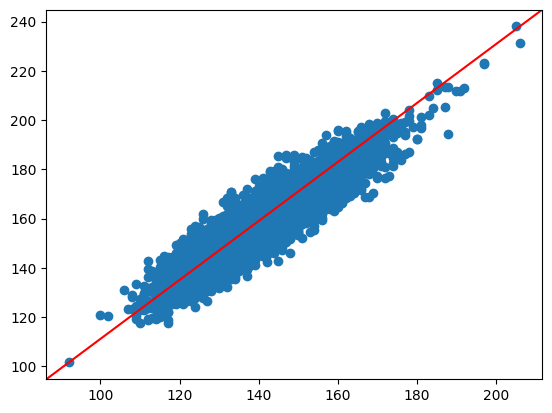

In [23]:
fig, ax = plt.subplots()
ax.scatter(x=game_total_df.total_posessions,y=game_total_df.uses)
ax.plot([0, 1], [0, 1], color='red', transform=ax.transAxes)

# Feature: Avg./max blocking rates of opponent team on court (segment)

### Game Player Level Blocking and Usage Stats 

In [24]:
segments_df

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",2,1,2,2
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[636a5d88531336e79c342588, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",3,3,1,2
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b7,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f45ed05764db467fe4e, 618d6f44ed05764db46...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",3,3,1,2
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b8,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 618d6f44ed05764db46...","[618d6f41ed05764db467fe3a, 61aa71a542908854158...",2,2,0,0
...,...,...,...,...,...,...,...,...,...,...
203715,648b3a9e98debb5769861e35,648b3a0b98debb576986198a,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc8, 61e5d81b335e7288b5d...",7,8,3,5
203716,648b3a9e98debb5769861e35,648b3a0b98debb576986198b,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc8, 61e5d81b335e7288b5d...",4,4,3,1
203717,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc8, 618dbab19a32a50e3d7...",1,0,1,0
203718,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",1,1,1,0


## 1. Get All players in each segment to make at same level as blocking stats df

In [25]:
segments_df["all_players_segment"] = segments_df["players_team1"]+segments_df["players_team2"] 
segments_df["all_players_team"] = [[1,1,1,1,1,2,2,2,2,2] for i in range(segments_df.shape[0])]
segments_df
segments_df_long = segments_df.explode(["all_players_segment","all_players_team"])
segments_df_long

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1
...,...,...,...,...,...,...,...,...,...,...,...,...
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2


## 2. Merge with blocking stats df

In [26]:
segments_players_usage_blocking_df

,segment_id,player_id,uses,blocks
0,636a5f91531336e79c3425b4,618d6f44ed05764db467fe48,1.0,0
1,636a5f91531336e79c3425b4,636a5d88531336e79c342588,1.0,0
2,636a5f91531336e79c3425b4,636a5d88531336e79c342589,1.0,0
3,636a5f91531336e79c3425b4,636a5d88531336e79c34258a,2.0,0
4,636a5f91531336e79c3425b4,618daeb7191f8b652ceb990b,0.0,0
...,...,...,...,...
2037195,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc0,0.0,0
2037196,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc2,4.0,0
2037197,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc6,1.0,0
2037198,648b3a0b98debb576986198e,618dbab09a32a50e3d7afdbb,1.0,0


### Combined segment info

In [27]:
segment_master_df = segments_df_long.merge(segments_players_usage_blocking_df,left_on=["segment_id","all_players_segment"],right_on=["segment_id","player_id"],how="inner")
segment_master_df

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,player_id,uses,blocks
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,636a5d88531336e79c342588,1.0,0
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,636a5d88531336e79c342589,1.0,0
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,636a5d88531336e79c34258a,2.0,0
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,618daeb7191f8b652ceb990b,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2,618dbab19a32a50e3d7afdc0,0.0,0
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2,618dbab19a32a50e3d7afdc2,4.0,0
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2,618dbab19a32a50e3d7afdc6,1.0,0
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2,618dbab09a32a50e3d7afdbb,1.0,0


In [28]:
#segment x player
segment_master_df[(segment_master_df.game_id==ObjectId("636a5fc5531336e79c342993")) & (segment_master_df.player_id==ObjectId("618d6f44ed05764db467fe48"))]


,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,player_id,uses,blocks
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0
10,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",2,1,2,2,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,0.0,0
40,636a5fc5531336e79c342993,636a5f91531336e79c3425b8,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 618d6f44ed05764db46...","[618d6f41ed05764db467fe3a, 61aa71a542908854158...",2,2,0,0,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,0.0,0
50,636a5fc5531336e79c342993,636a5f91531336e79c3425b9,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f42ed05764db467fe41, 61aa71a542908854158...",2,2,0,3,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,1
60,636a5fc5531336e79c342993,636a5f91531336e79c3425ba,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",2,2,1,3,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,2.0,0
200,636a5fc5531336e79c342993,636a5f91531336e79c3425c8,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f42ed05764db467fe41, 61aa71a542908854158...",2,2,0,2,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,0.0,0
210,636a5fc5531336e79c342993,636a5f91531336e79c3425c9,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f42ed05764db467fe41, 618d6f41ed05764db46...",1,2,0,3,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0
220,636a5fc5531336e79c342993,636a5f91531336e79c3425ca,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 618d6f44ed05764db46...","[618d6f41ed05764db467fe3a, 61aa71a542908854158...",3,3,1,3,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0
230,636a5fc5531336e79c342993,636a5f91531336e79c3425cb,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 61aa71a542908854158...",0,0,0,0,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,0.0,0
240,636a5fc5531336e79c342993,636a5f91531336e79c3425cc,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1,1,1,0,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0


In [29]:
segment_master_df.query("all_players_team==1").groupby("game_id",as_index=False)["uses","possessions_team1"].sum()


E:\AppData\Local\Temp\ipykernel_23228\4041463725.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  segment_master_df.query("all_players_team==1").groupby("game_id",as_index=False)["uses","possessions_team1"].sum()


,game_id,uses,possessions_team1
0,636a5fc5531336e79c342993,75.92,330
1,636a61967b3d0a3470cf7b1a,74.16,365
2,636ac7918ab5de1c94cf9f83,78.92,355
3,636acac88ab5de1c94cfa752,99.12,400
4,636c2fe1af77c98d5eb154cf,76.68,360
...,...,...,...
6053,6467d0dc37daa734e1f5bddb,70.60,325
6054,6467d12137daa734e1f5c36a,75.92,355
6055,6467d16737daa734e1f5c849,70.92,310
6056,6467d1df37daa734e1f5cdf9,68.16,325


In [30]:
segment_master_df

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,player_id,uses,blocks
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,636a5d88531336e79c342588,1.0,0
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,636a5d88531336e79c342589,1.0,0
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,636a5d88531336e79c34258a,2.0,0
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,618daeb7191f8b652ceb990b,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2,618dbab19a32a50e3d7afdc0,0.0,0
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2,618dbab19a32a50e3d7afdc2,4.0,0
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2,618dbab19a32a50e3d7afdc6,1.0,0
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2,618dbab09a32a50e3d7afdbb,1.0,0


### Aggregate metrics of a player in a game across all segments  

In [31]:
segment_master_df_game_player = segment_master_df.groupby(["game_id","player_id","all_players_team"],as_index=False)["possessions_team1","possessions_team2","twoshots_team1","twoshots_team2","uses","blocks"].sum()
segment_master_df_game_player

E:\AppData\Local\Temp\ipykernel_23228\208369183.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  segment_master_df_game_player = segment_master_df.groupby(["game_id","player_id","all_players_team"],as_index=False)["possessions_team1","possessions_team2","twoshots_team1","twoshots_team2","uses","blocks"].sum()


,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks
0,636a5fc5531336e79c342993,618d6f41ed05764db467fe36,2,50,52,14,33,8.00,0
1,636a5fc5531336e79c342993,618d6f41ed05764db467fe39,2,29,30,13,17,3.00,0
2,636a5fc5531336e79c342993,618d6f41ed05764db467fe3a,2,51,52,17,26,14.64,0
3,636a5fc5531336e79c342993,618d6f42ed05764db467fe40,2,51,52,16,34,12.76,2
4,636a5fc5531336e79c342993,618d6f42ed05764db467fe41,2,60,61,21,37,13.08,1
...,...,...,...,...,...,...,...,...,...
122090,648b3a9e98debb5769861e35,636d88511f186408f6c60d62,1,65,65,30,32,12.76,2
122091,648b3a9e98debb5769861e35,636d88521f186408f6c60d63,1,20,18,6,11,6.00,0
122092,648b3a9e98debb5769861e35,636d88521f186408f6c60d64,1,46,46,23,20,10.20,0
122093,648b3a9e98debb5769861e35,636d88521f186408f6c60d65,1,21,22,7,11,4.00,0


### When calculating block ratio take twoshot attempts of opponent team

In [32]:
segment_master_df_game_player["two_shots_for_blocks"] = np.where(segment_master_df_game_player.all_players_team==1,\
                                                        segment_master_df_game_player.twoshots_team2,\
                                                        segment_master_df_game_player.twoshots_team1)
segment_master_df_game_player

,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,two_shots_for_blocks
0,636a5fc5531336e79c342993,618d6f41ed05764db467fe36,2,50,52,14,33,8.00,0,14
1,636a5fc5531336e79c342993,618d6f41ed05764db467fe39,2,29,30,13,17,3.00,0,13
2,636a5fc5531336e79c342993,618d6f41ed05764db467fe3a,2,51,52,17,26,14.64,0,17
3,636a5fc5531336e79c342993,618d6f42ed05764db467fe40,2,51,52,16,34,12.76,2,16
4,636a5fc5531336e79c342993,618d6f42ed05764db467fe41,2,60,61,21,37,13.08,1,21
...,...,...,...,...,...,...,...,...,...,...
122090,648b3a9e98debb5769861e35,636d88511f186408f6c60d62,1,65,65,30,32,12.76,2,32
122091,648b3a9e98debb5769861e35,636d88521f186408f6c60d63,1,20,18,6,11,6.00,0,11
122092,648b3a9e98debb5769861e35,636d88521f186408f6c60d64,1,46,46,23,20,10.20,0,20
122093,648b3a9e98debb5769861e35,636d88521f186408f6c60d65,1,21,22,7,11,4.00,0,11


### When calculating usage ratio take posessions of same team

In [33]:
segment_master_df_game_player["posessions_for_usage"] = np.where(segment_master_df_game_player.all_players_team==1,\
                                                        segment_master_df_game_player.possessions_team1,\
                                                        segment_master_df_game_player.possessions_team2)

segment_master_df_game_player

,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,two_shots_for_blocks,posessions_for_usage
0,636a5fc5531336e79c342993,618d6f41ed05764db467fe36,2,50,52,14,33,8.00,0,14,52
1,636a5fc5531336e79c342993,618d6f41ed05764db467fe39,2,29,30,13,17,3.00,0,13,30
2,636a5fc5531336e79c342993,618d6f41ed05764db467fe3a,2,51,52,17,26,14.64,0,17,52
3,636a5fc5531336e79c342993,618d6f42ed05764db467fe40,2,51,52,16,34,12.76,2,16,52
4,636a5fc5531336e79c342993,618d6f42ed05764db467fe41,2,60,61,21,37,13.08,1,21,61
...,...,...,...,...,...,...,...,...,...,...,...
122090,648b3a9e98debb5769861e35,636d88511f186408f6c60d62,1,65,65,30,32,12.76,2,32,65
122091,648b3a9e98debb5769861e35,636d88521f186408f6c60d63,1,20,18,6,11,6.00,0,11,20
122092,648b3a9e98debb5769861e35,636d88521f186408f6c60d64,1,46,46,23,20,10.20,0,20,46
122093,648b3a9e98debb5769861e35,636d88521f186408f6c60d65,1,21,22,7,11,4.00,0,11,21


In [34]:
segment_master_df["all_players_team_id"] = np.where(segment_master_df.all_players_team==1,segment_master_df.teamid1,segment_master_df.teamid2)
segment_master_df

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,player_id,uses,blocks,all_players_team_id
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,618d6f44ed05764db467fe48,1.0,0,5e875e684dc25ebee5af6797
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,636a5d88531336e79c342588,1.0,0,5e875e684dc25ebee5af6797
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,636a5d88531336e79c342589,1.0,0,5e875e684dc25ebee5af6797
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,636a5d88531336e79c34258a,2.0,0,5e875e684dc25ebee5af6797
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,618daeb7191f8b652ceb990b,0.0,0,5e875e684dc25ebee5af6797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2,618dbab19a32a50e3d7afdc0,0.0,0,5e875e684dc25ebee5af6b7b
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2,618dbab19a32a50e3d7afdc2,4.0,0,5e875e684dc25ebee5af6b7b
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2,618dbab19a32a50e3d7afdc6,1.0,0,5e875e684dc25ebee5af6b7b
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2,618dbab09a32a50e3d7afdbb,1.0,0,5e875e684dc25ebee5af6b7b


## Create master Team - Game - Player Dataframe to track which players played which game

#### Get all games of teams using segment_df
#### Get all players of a team - can be part of many different segments
#### Join 2 together on team id - we get all possible team_id x game_id x player_id  - some of these are ficticious

In [35]:
team_game_info = segment_master_df[["all_players_team_id","game_id"]].drop_duplicates().rename(columns={"all_players_team_id":"team_id"})
team_player_info = segment_master_df[["all_players_team_id","player_id"]].drop_duplicates().rename(columns={"all_players_team_id":"team_id"})
team_game_player_info = team_game_info.merge(team_player_info,how="left",on="team_id")
team_game_player_info

,team_id,game_id,player_id
0,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,618d6f44ed05764db467fe48
1,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c342588
2,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c342589
3,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c34258a
4,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,618daeb7191f8b652ceb990b
...,...,...,...
170298,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,618dbab09a32a50e3d7afdba
170299,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,61aa8b807418a25e96b9b716
170300,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,618dbab19a32a50e3d7afdc4
170301,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,636d86131f186408f6c56e38


### Merge with aggregated segment df to check whether player of a team played that game or not 

In [36]:
team_game_player_stats = team_game_player_info.merge(segment_master_df_game_player,on=["game_id","player_id"],how="left")
team_game_player_stats["player_mode"] = np.where(team_game_player_stats.all_players_team.isna(),0,1)
team_game_player_stats

,team_id,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,two_shots_for_blocks,posessions_for_usage,player_mode
0,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,618d6f44ed05764db467fe48,1.0,32.0,32.0,10.0,24.0,10.00,2.0,24.0,32.0,1
1,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c342588,1.0,49.0,50.0,19.0,32.0,10.64,0.0,32.0,49.0,1
2,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c342589,1.0,57.0,57.0,20.0,33.0,13.44,0.0,33.0,57.0,1
3,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c34258a,1.0,10.0,10.0,5.0,6.0,3.00,0.0,6.0,10.0,1
4,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,618daeb7191f8b652ceb990b,1.0,20.0,21.0,10.0,18.0,6.00,0.0,18.0,20.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170298,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,618dbab09a32a50e3d7afdba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
170299,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,61aa8b807418a25e96b9b716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
170300,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,618dbab19a32a50e3d7afdc4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
170301,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,636d86131f186408f6c56e38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [37]:
team_game_player_stats_df = team_game_player_stats.merge(games_df[["game_id","date"]],on="game_id",how="left")
team_game_player_stats_df

,team_id,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,two_shots_for_blocks,posessions_for_usage,player_mode,date
0,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,618d6f44ed05764db467fe48,1.0,32.0,32.0,10.0,24.0,10.00,2.0,24.0,32.0,1,11/7/22
1,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c342588,1.0,49.0,50.0,19.0,32.0,10.64,0.0,32.0,49.0,1,11/7/22
2,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c342589,1.0,57.0,57.0,20.0,33.0,13.44,0.0,33.0,57.0,1,11/7/22
3,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,636a5d88531336e79c34258a,1.0,10.0,10.0,5.0,6.0,3.00,0.0,6.0,10.0,1,11/7/22
4,5e875e684dc25ebee5af6797,636a5fc5531336e79c342993,618daeb7191f8b652ceb990b,1.0,20.0,21.0,10.0,18.0,6.00,0.0,18.0,20.0,1,11/7/22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170298,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,618dbab09a32a50e3d7afdba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3/1/23
170299,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,61aa8b807418a25e96b9b716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3/1/23
170300,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,618dbab19a32a50e3d7afdc4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3/1/23
170301,5e875e684dc25ebee5af6b7b,648b3a9e98debb5769861e35,636d86131f186408f6c56e38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3/1/23


In [38]:
team_game_player_stats_df.date = pd.to_datetime(team_game_player_stats_df.date)

team_game_player_stats_df = team_game_player_stats_df.sort_values(by=["team_id","player_id","date"],ascending=(1,1,1)).reset_index(drop=True)
team_game_player_stats_df

,team_id,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,two_shots_for_blocks,posessions_for_usage,player_mode,date
0,5e875e684dc25ebee5af674b,636d902e1f186408f6c798fc,618d6acced05764db467c654,2.0,38.0,37.0,17.0,20.0,3.00,0.0,17.0,37.0,1,2022-11-07
1,5e875e684dc25ebee5af674b,636e84fb7d85d389f9e3e868,618d6acced05764db467c654,1.0,31.0,31.0,24.0,27.0,2.00,0.0,27.0,31.0,1,2022-11-10
2,5e875e684dc25ebee5af674b,63718ac9c392223c6faf0abc,618d6acced05764db467c654,1.0,44.0,46.0,27.0,21.0,6.00,0.0,21.0,44.0,1,2022-11-13
3,5e875e684dc25ebee5af674b,6375be921a84183808fda2ec,618d6acced05764db467c654,1.0,37.0,37.0,22.0,20.0,3.00,0.0,20.0,37.0,1,2022-11-16
4,5e875e684dc25ebee5af674b,637cd264a93e7efe6e8af8ad,618d6acced05764db467c654,2.0,28.0,28.0,16.0,14.0,4.00,0.0,16.0,28.0,1,2022-11-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170298,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd2,2.0,30.0,30.0,20.0,9.0,7.64,0.0,20.0,30.0,1,2023-02-20
170299,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd3,2.0,30.0,31.0,19.0,14.0,9.00,3.0,19.0,31.0,1,2023-02-20
170300,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd4,2.0,21.0,21.0,12.0,4.0,2.00,0.0,12.0,21.0,1,2023-02-20
170301,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd5,2.0,21.0,23.0,14.0,10.0,4.00,0.0,14.0,23.0,1,2023-02-20


In [39]:
team_game_player_stats_df

,team_id,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,two_shots_for_blocks,posessions_for_usage,player_mode,date
0,5e875e684dc25ebee5af674b,636d902e1f186408f6c798fc,618d6acced05764db467c654,2.0,38.0,37.0,17.0,20.0,3.00,0.0,17.0,37.0,1,2022-11-07
1,5e875e684dc25ebee5af674b,636e84fb7d85d389f9e3e868,618d6acced05764db467c654,1.0,31.0,31.0,24.0,27.0,2.00,0.0,27.0,31.0,1,2022-11-10
2,5e875e684dc25ebee5af674b,63718ac9c392223c6faf0abc,618d6acced05764db467c654,1.0,44.0,46.0,27.0,21.0,6.00,0.0,21.0,44.0,1,2022-11-13
3,5e875e684dc25ebee5af674b,6375be921a84183808fda2ec,618d6acced05764db467c654,1.0,37.0,37.0,22.0,20.0,3.00,0.0,20.0,37.0,1,2022-11-16
4,5e875e684dc25ebee5af674b,637cd264a93e7efe6e8af8ad,618d6acced05764db467c654,2.0,28.0,28.0,16.0,14.0,4.00,0.0,16.0,28.0,1,2022-11-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170298,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd2,2.0,30.0,30.0,20.0,9.0,7.64,0.0,20.0,30.0,1,2023-02-20
170299,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd3,2.0,30.0,31.0,19.0,14.0,9.00,3.0,19.0,31.0,1,2023-02-20
170300,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd4,2.0,21.0,21.0,12.0,4.0,2.00,0.0,12.0,21.0,1,2023-02-20
170301,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd5,2.0,21.0,23.0,14.0,10.0,4.00,0.0,14.0,23.0,1,2023-02-20


In [40]:
last_1_games_perf = team_game_player_stats_df.groupby(["team_id","player_id"],as_index=False)["uses","blocks","two_shots_for_blocks","posessions_for_usage"].rolling(closed="left",window=1).sum()
last_3_games_perf = team_game_player_stats_df.groupby(["team_id","player_id"],sort=False,as_index=False)["uses","blocks","two_shots_for_blocks","posessions_for_usage"].rolling(closed="left",window=3).sum()
last_5_games_perf = team_game_player_stats_df.groupby(["team_id","player_id"],sort=False,as_index=False)["uses","blocks","two_shots_for_blocks","posessions_for_usage"].rolling(closed="left",window=5).sum()
last_10_games_perf = team_game_player_stats_df.groupby(["team_id","player_id"],sort=False,as_index=False)["uses","blocks","two_shots_for_blocks","posessions_for_usage"].rolling(closed="left",window=10).sum()

# last_1_games_avail = team_game_player_stats_df.groupby(["team_id","player_id"],as_index=False)["uses"].rolling(closed="left",window=1,min_periods=1).count().rename(columns={"uses":"last_1_num_games"})
# last_3_games_avail = team_game_player_stats_df.groupby(["team_id","player_id"],as_index=False)["uses"].rolling(closed="left",window=3,min_periods=1).count().rename(columns={"uses":"last_3_num_games"})
# last_5_games_avail = team_game_player_stats_df.groupby(["team_id","player_id"],as_index=False)["uses"].rolling(closed="left",window=5,min_periods=1).count().rename(columns={"uses":"last_5_num_games"})
# last_10_games_avail = team_game_player_stats_df.groupby(["team_id","player_id"],as_index=False)["uses"].rolling(closed="left",window=10,min_periods=1).count().rename(columns={"uses":"last_10_num_games"})


E:\AppData\Local\Temp\ipykernel_23228\3441455221.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  last_1_games_perf = team_game_player_stats_df.groupby(["team_id","player_id"],as_index=False)["uses","blocks","two_shots_for_blocks","posessions_for_usage"].rolling(closed="left",window=1).sum()
E:\AppData\Local\Temp\ipykernel_23228\3441455221.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  last_3_games_perf = team_game_player_stats_df.groupby(["team_id","player_id"],sort=False,as_index=False)["uses","blocks","two_shots_for_blocks","posessions_for_usage"].rolling(closed="left",window=3).sum()
E:\AppData\Local\Temp\ipykernel_23228\3441455221.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  last_5_games_perf = team_game_player_stats_df.groupby

In [41]:
team_game_player_stats_df["last_1_game_usage_ratio"] = (last_1_games_perf.uses/last_1_games_perf.posessions_for_usage)
team_game_player_stats_df["last_3_game_usage_ratio"] = (last_3_games_perf.uses/last_3_games_perf.posessions_for_usage)
team_game_player_stats_df["last_5_game_usage_ratio"] = (last_5_games_perf.uses/last_5_games_perf.posessions_for_usage)
team_game_player_stats_df["last_10_game_usage_ratio"] = (last_10_games_perf.uses/last_10_games_perf.posessions_for_usage)

team_game_player_stats_df["last_1_game_blocks_ratio"] = (last_1_games_perf.blocks/last_1_games_perf.two_shots_for_blocks)
team_game_player_stats_df["last_3_game_blocks_ratio"] = (last_3_games_perf.blocks/last_3_games_perf.two_shots_for_blocks)
team_game_player_stats_df["last_5_game_blocks_ratio"] = (last_5_games_perf.blocks/last_5_games_perf.two_shots_for_blocks)
team_game_player_stats_df["last_10_game_blocks_ratio"] = (last_10_games_perf.blocks/last_10_games_perf.two_shots_for_blocks)

# team_game_player_stats_df["last_1_num_games"] = last_1_games_avail["last_1_num_games"]
# team_game_player_stats_df["last_3_num_games"] = last_3_games_avail["last_3_num_games"]
# team_game_player_stats_df["last_5_num_games"] = last_5_games_avail["last_5_num_games"]
# team_game_player_stats_df["last_10_num_games"] = last_10_games_avail["last_10_num_games"]

In [42]:
team_game_player_stats_df.head(15)

,team_id,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,...,player_mode,date,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,last_1_game_blocks_ratio,last_3_game_blocks_ratio,last_5_game_blocks_ratio,last_10_game_blocks_ratio
0,5e875e684dc25ebee5af674b,636d902e1f186408f6c798fc,618d6acced05764db467c654,2.0,38.0,37.0,17.0,20.0,3.0,0.0,...,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5e875e684dc25ebee5af674b,636e84fb7d85d389f9e3e868,618d6acced05764db467c654,1.0,31.0,31.0,24.0,27.0,2.0,0.0,...,1,2022-11-10,0.081081,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,5e875e684dc25ebee5af674b,63718ac9c392223c6faf0abc,618d6acced05764db467c654,1.0,44.0,46.0,27.0,21.0,6.0,0.0,...,1,2022-11-13,0.064516,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
3,5e875e684dc25ebee5af674b,6375be921a84183808fda2ec,618d6acced05764db467c654,1.0,37.0,37.0,22.0,20.0,3.0,0.0,...,1,2022-11-16,0.136364,0.098214,NaN,NaN,0.000000,0.000,NaN,NaN
4,5e875e684dc25ebee5af674b,637cd264a93e7efe6e8af8ad,618d6acced05764db467c654,2.0,28.0,28.0,16.0,14.0,4.0,0.0,...,1,2022-11-21,0.081081,0.098214,NaN,NaN,0.000000,0.000,NaN,NaN
5,5e875e684dc25ebee5af674b,637dbab0a01fb92c4acb81af,618d6acced05764db467c654,1.0,31.0,30.0,17.0,17.0,5.0,0.0,...,1,2022-11-22,0.142857,0.119266,0.101695,NaN,0.000000,0.000,0.000000,NaN
6,5e875e684dc25ebee5af674b,637f00511280212ca084ebd4,618d6acced05764db467c654,1.0,18.0,18.0,11.0,11.0,0.0,0.0,...,1,2022-11-23,0.161290,0.125000,0.116959,NaN,0.000000,0.000,0.000000,NaN
7,5e875e684dc25ebee5af674b,63881860f940f915c71c7f69,618d6acced05764db467c654,1.0,31.0,30.0,17.0,12.0,6.0,1.0,...,1,2022-11-30,0.000000,0.116883,0.113924,NaN,0.000000,0.000,0.000000,NaN
8,5e875e684dc25ebee5af674b,638d0ed796d81e79d170db30,618d6acced05764db467c654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2022-12-04,0.193548,0.137500,0.124138,NaN,0.083333,0.025,0.013158,NaN
9,5e875e684dc25ebee5af674b,6395f1828e5a1255938bdff9,618d6acced05764db467c654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,2022-12-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
team_game_player_stats_df.isna().sum()/team_game_player_stats_df.shape[0]

team_id                      0.000000
game_id                      0.000000
player_id                    0.000000
all_players_team             0.283072
possessions_team1            0.283072
possessions_team2            0.283072
twoshots_team1               0.283072
twoshots_team2               0.283072
uses                         0.283072
blocks                       0.283072
two_shots_for_blocks         0.283072
posessions_for_usage         0.283072
player_mode                  0.000000
date                         0.000000
last_1_game_usage_ratio      0.332848
last_3_game_usage_ratio      0.475729
last_5_game_usage_ratio      0.555328
last_10_game_usage_ratio     0.695002
last_1_game_blocks_ratio     0.344551
last_3_game_blocks_ratio     0.475776
last_5_game_blocks_ratio     0.555328
last_10_game_blocks_ratio    0.695002
dtype: float64

### As we have stats for each player for a game, now we can join this info at segment level and calculate averages for all players of opponent team

In [44]:
segments_df

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",2,1,2,2,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[636a5d88531336e79c342588, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",3,3,1,2,"[636a5d88531336e79c342588, 636a5d88531336e79c3...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b7,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f45ed05764db467fe4e, 618d6f44ed05764db46...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",3,3,1,2,"[618d6f45ed05764db467fe4e, 618d6f44ed05764db46...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b8,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 618d6f44ed05764db46...","[618d6f41ed05764db467fe3a, 61aa71a542908854158...",2,2,0,0,"[618d6f44ed05764db467fe48, 618d6f44ed05764db46...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
...,...,...,...,...,...,...,...,...,...,...,...,...
203715,648b3a9e98debb5769861e35,648b3a0b98debb576986198a,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc8, 61e5d81b335e7288b5d...",7,8,3,5,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
203716,648b3a9e98debb5769861e35,648b3a0b98debb576986198b,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc8, 61e5d81b335e7288b5d...",4,4,3,1,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
203717,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc8, 618dbab19a32a50e3d7...",1,0,1,0,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"
203718,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",1,1,1,0,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[1, 1, 1, 1, 1, 2, 2, 2, 2, 2]"


In [45]:
segments_df_long = segments_df.explode(["all_players_segment","all_players_team"])
segments_df_long

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1
...,...,...,...,...,...,...,...,...,...,...,...,...
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2


In [46]:
segments_df_long["all_players_team_id"] = np.where(segments_df_long.all_players_team==1,segments_df_long.teamid1,segments_df_long.teamid2)
segments_df_long

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,all_players_team_id
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,5e875e684dc25ebee5af6797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2,5e875e684dc25ebee5af6b7b
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2,5e875e684dc25ebee5af6b7b
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2,5e875e684dc25ebee5af6b7b
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2,5e875e684dc25ebee5af6b7b


In [47]:
team_game_player_stats_df

,team_id,game_id,player_id,all_players_team,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,uses,blocks,...,player_mode,date,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,last_1_game_blocks_ratio,last_3_game_blocks_ratio,last_5_game_blocks_ratio,last_10_game_blocks_ratio
0,5e875e684dc25ebee5af674b,636d902e1f186408f6c798fc,618d6acced05764db467c654,2.0,38.0,37.0,17.0,20.0,3.00,0.0,...,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5e875e684dc25ebee5af674b,636e84fb7d85d389f9e3e868,618d6acced05764db467c654,1.0,31.0,31.0,24.0,27.0,2.00,0.0,...,1,2022-11-10,0.081081,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,5e875e684dc25ebee5af674b,63718ac9c392223c6faf0abc,618d6acced05764db467c654,1.0,44.0,46.0,27.0,21.0,6.00,0.0,...,1,2022-11-13,0.064516,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,5e875e684dc25ebee5af674b,6375be921a84183808fda2ec,618d6acced05764db467c654,1.0,37.0,37.0,22.0,20.0,3.00,0.0,...,1,2022-11-16,0.136364,0.098214,NaN,NaN,0.0,0.0,NaN,NaN
4,5e875e684dc25ebee5af674b,637cd264a93e7efe6e8af8ad,618d6acced05764db467c654,2.0,28.0,28.0,16.0,14.0,4.00,0.0,...,1,2022-11-21,0.081081,0.098214,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170298,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd2,2.0,30.0,30.0,20.0,9.0,7.64,0.0,...,1,2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170299,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd3,2.0,30.0,31.0,19.0,14.0,9.00,3.0,...,1,2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170300,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd4,2.0,21.0,21.0,12.0,4.0,2.00,0.0,...,1,2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170301,63f451982d092e49c3dcccc9,63f451b22d092e49c3dcd14b,63f451ac2d092e49c3dcccd5,2.0,21.0,23.0,14.0,10.0,4.00,0.0,...,1,2023-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
segment_df_long_stats = segments_df_long.merge(team_game_player_stats_df,left_on=["all_players_team_id","game_id","all_players_segment"],right_on=["team_id","game_id","player_id"],how="left")
pd.options.display.max_columns=None

segment_df_long_stats.head(15)

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1_x,possessions_team2_x,twoshots_team1_x,twoshots_team2_x,all_players_segment,all_players_team_x,all_players_team_id,team_id,player_id,all_players_team_y,possessions_team1_y,possessions_team2_y,twoshots_team1_y,twoshots_team2_y,uses,blocks,two_shots_for_blocks,posessions_for_usage,player_mode,date,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,last_1_game_blocks_ratio,last_3_game_blocks_ratio,last_5_game_blocks_ratio,last_10_game_blocks_ratio
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,618d6f44ed05764db467fe48,1.0,32.0,32.0,10.0,24.0,10.00,2.0,24.0,32.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,636a5d88531336e79c342588,1.0,49.0,50.0,19.0,32.0,10.64,0.0,32.0,49.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,636a5d88531336e79c342589,1.0,57.0,57.0,20.0,33.0,13.44,0.0,33.0,57.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,636a5d88531336e79c34258a,1.0,10.0,10.0,5.0,6.0,3.00,0.0,6.0,10.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,618daeb7191f8b652ceb990b,1.0,20.0,21.0,10.0,18.0,6.00,0.0,18.0,20.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f41ed05764db467fe3a,2,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,618d6f41ed05764db467fe3a,2.0,51.0,52.0,17.0,26.0,14.64,0.0,17.0,52.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f42ed05764db467fe41,2,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,618d6f42ed05764db467fe41,2.0,60.0,61.0,21.0,37.0,13.08,1.0,21.0,61.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,61aa71a54290885415884cf5,2,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,61aa71a54290885415884cf5,2.0,48.0,46.0,14.0,31.0,8.00,0.0,14.0,46.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f4

In [49]:
segment_df_long_stats.isna().sum()/segment_df_long_stats.shape[0]

game_id                      0.000000
segment_id                   0.000000
teamid1                      0.000000
teamid2                      0.000000
players_team1                0.000000
players_team2                0.000000
possessions_team1_x          0.000000
possessions_team2_x          0.000000
twoshots_team1_x             0.000000
twoshots_team2_x             0.000000
all_players_segment          0.000000
all_players_team_x           0.000000
all_players_team_id          0.000000
team_id                      0.000000
player_id                    0.000000
all_players_team_y           0.000000
possessions_team1_y          0.000000
possessions_team2_y          0.000000
twoshots_team1_y             0.000000
twoshots_team2_y             0.000000
uses                         0.000000
blocks                       0.000000
two_shots_for_blocks         0.000000
posessions_for_usage         0.000000
player_mode                  0.000000
date                         0.000000
last_1_game_

# Defining High Blocking Ratio Threshold

In [50]:
(segment_df_long_stats.last_1_game_blocks_ratio.quantile(.75),
segment_df_long_stats.last_1_game_blocks_ratio.quantile(.8),
segment_df_long_stats.last_1_game_blocks_ratio.quantile(.9),
segment_df_long_stats.last_1_game_blocks_ratio.quantile(.95))

(0.025, 0.034482758620689655, 0.0625, 0.09090909090909091)

In [51]:
(segment_df_long_stats.last_3_game_blocks_ratio.quantile(.75),
segment_df_long_stats.last_3_game_blocks_ratio.quantile(.8),
segment_df_long_stats.last_3_game_blocks_ratio.quantile(.9),
segment_df_long_stats.last_3_game_blocks_ratio.quantile(.95))

(0.02531645569620253, 0.03125, 0.05, 0.07142857142857142)

In [52]:
(segment_df_long_stats.last_5_game_blocks_ratio.quantile(.75),
segment_df_long_stats.last_5_game_blocks_ratio.quantile(.8),
segment_df_long_stats.last_5_game_blocks_ratio.quantile(.9),
segment_df_long_stats.last_5_game_blocks_ratio.quantile(.95))

(0.024691358024691357,
 0.029850746268656716,
 0.046511627906976744,
 0.06493506493506493)

In [53]:
(segment_df_long_stats.last_10_game_blocks_ratio.quantile(.75),
segment_df_long_stats.last_10_game_blocks_ratio.quantile(.8),
segment_df_long_stats.last_10_game_blocks_ratio.quantile(.9),
segment_df_long_stats.last_10_game_blocks_ratio.quantile(.95))

(0.02390438247011952,
 0.028368794326241134,
 0.043243243243243246,
 0.06043956043956044)

In [54]:
BLOCKING_THRESHOLD = 0.0306

In [55]:
segment_df_long_stats["blocker"] = np.where(segment_df_long_stats.last_10_game_blocks_ratio>=0.0306,True,False)
segment_df_long_stats["blocker"].isna().sum()

0

#### This dataframe has 5 players each at game,segment and team id level, we will aggregate across these 5 players to count number of blockers 

In [56]:
segment_df_long_stats.loc[\
    (segment_df_long_stats.game_id==ObjectId('636a5fc5531336e79c342993'))&\
    (segment_df_long_stats.segment_id==ObjectId('636a5f91531336e79c3425b4'))&\
    (segment_df_long_stats.team_id==ObjectId('5e875e684dc25ebee5af6797'))]

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1_x,possessions_team2_x,twoshots_team1_x,twoshots_team2_x,all_players_segment,all_players_team_x,all_players_team_id,team_id,player_id,all_players_team_y,possessions_team1_y,possessions_team2_y,twoshots_team1_y,twoshots_team2_y,uses,blocks,two_shots_for_blocks,posessions_for_usage,player_mode,date,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,last_1_game_blocks_ratio,last_3_game_blocks_ratio,last_5_game_blocks_ratio,last_10_game_blocks_ratio,blocker
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,618d6f44ed05764db467fe48,1.0,32.0,32.0,10.0,24.0,10.00,2.0,24.0,32.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,636a5d88531336e79c342588,1.0,49.0,50.0,19.0,32.0,10.64,0.0,32.0,49.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,636a5d88531336e79c342589,1.0,57.0,57.0,20.0,33.0,13.44,0.0,33.0,57.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,636a5d88531336e79c34258a,1.0,10.0,10.0,5.0,6.0,3.00,0.0,6.0,10.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6797,618daeb7191f8b652ceb990b,1.0,20.0,21.0,10.0,18.0,6.00,0.0,18.0,20.0,1,2022-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [57]:
segment_team_level_blockers = segment_df_long_stats.groupby(["game_id","segment_id","team_id"],as_index=False)["blocker"].sum().rename(columns={"blocker":"num_blockers_on_team"})

In [58]:
segment_team_level_blockers

,game_id,segment_id,team_id,num_blockers_on_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,0
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6953,0
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,0
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6953,0
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,0
...,...,...,...,...
407435,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b7b,1
407436,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,0
407437,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b7b,1
407438,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,0


In [59]:
feature_list_2_game_segment_team_level = segment_team_level_blockers
feature_list_2_game_segment_team_level

,game_id,segment_id,team_id,num_blockers_on_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,0
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6953,0
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,0
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6953,0
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,0
...,...,...,...,...
407435,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b7b,1
407436,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,0
407437,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b7b,1
407438,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,0


In [60]:
feature_list_3_game_segment_player_level = segment_df_long_stats[['game_id','segment_id','player_id','team_id','last_1_game_usage_ratio','last_3_game_usage_ratio','last_5_game_usage_ratio','last_10_game_usage_ratio']].drop_duplicates()
feature_list_3_game_segment_player_level

,game_id,segment_id,player_id,team_id,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f44ed05764db467fe48,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,636a5d88531336e79c342588,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,636a5d88531336e79c342589,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,636a5d88531336e79c34258a,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618daeb7191f8b652ceb990b,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc0,5e875e684dc25ebee5af6b7b,0.330667,0.340267,0.324444,0.325106
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc2,5e875e684dc25ebee5af6b7b,0.286061,0.223929,0.253744,0.259738
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc6,5e875e684dc25ebee5af6b7b,0.134286,0.065455,0.100909,0.107273
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab09a32a50e3d7afdbb,5e875e684dc25ebee5af6b7b,0.136364,0.145161,0.144231,0.164773


### Feature: Opposition Player Characteristics

In [86]:
segments_df_long = segments_df.explode(["all_players_segment","all_players_team"])
segments_df_long

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1
...,...,...,...,...,...,...,...,...,...,...,...,...
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2


In [87]:
segments_df_long["all_players_team_id"] = np.where(segments_df_long.all_players_team==1,segments_df_long.teamid1,segments_df_long.teamid2)
segments_df_long

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,all_players_team_id
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,5e875e684dc25ebee5af6797
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,5e875e684dc25ebee5af6797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2,5e875e684dc25ebee5af6b7b
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2,5e875e684dc25ebee5af6b7b
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2,5e875e684dc25ebee5af6b7b
203719,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2,5e875e684dc25ebee5af6b7b


In [88]:
players_df

,player,height,LBA_position,Genius_position,year,seasonid
0,618ff2add1901c63278a2703,78,Mid,F,Sr,63502c8a4e970ea2c1102c04
1,618ff2add1901c63278a2704,81,Big,F,So,63502c8a4e970ea2c1102c04
2,618ff2add1901c63278a2709,81,Big,F,Sr,63502c8a4e970ea2c1102c04
3,618ff2add1901c63278a270a,81,Big,F,Sr,63502c8a4e970ea2c1102c04
4,618ff2add1901c63278a270b,81,Big,F,Jr,63502c8a4e970ea2c1102c04
...,...,...,...,...,...,...
4699,625648232c06a1d63387153e,74,Small,G,So,63502c804e970ea2c1102b18
4700,636d8a9d1f186408f6c6a282,82,Big,F,Fr,63502c804e970ea2c1102b18
4701,636d8a9d1f186408f6c6a283,77,Mid,G,Fr,63502c804e970ea2c1102b18
4702,637866864650d03587041f9a,74,Small,G,Fr,63502c804e970ea2c1102b18


In [89]:
segments_df_long_player_chars = segments_df_long.merge(players_df,how="left",left_on="all_players_segment",right_on="player")
segments_df_long_player_chars

,game_id,segment_id,teamid1,teamid2,players_team1,players_team2,possessions_team1,possessions_team2,twoshots_team1,twoshots_team2,all_players_segment,all_players_team,all_players_team_id,player,height,LBA_position,Genius_position,year,seasonid
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618d6f44ed05764db467fe48,1,5e875e684dc25ebee5af6797,618d6f44ed05764db467fe48,77.0,Mid,F,Sr,63502c804e970ea2c1102b09
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342588,1,5e875e684dc25ebee5af6797,636a5d88531336e79c342588,81.0,Big,F,Fr,63502c804e970ea2c1102b09
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c342589,1,5e875e684dc25ebee5af6797,636a5d88531336e79c342589,73.0,Small,G,Sr,63502c804e970ea2c1102b09
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,636a5d88531336e79c34258a,1,5e875e684dc25ebee5af6797,636a5d88531336e79c34258a,72.0,Small,G,So,63502c804e970ea2c1102b09
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",4,5,2,4,618daeb7191f8b652ceb990b,1,5e875e684dc25ebee5af6797,618daeb7191f8b652ceb990b,75.0,Mid,G,Sr,63502c804e970ea2c1102b09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc0,2,5e875e684dc25ebee5af6b7b,618dbab19a32a50e3d7afdc0,71.0,Small,G,Jr,63502c8a4e970ea2c1102c01
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc2,2,5e875e684dc25ebee5af6b7b,618dbab19a32a50e3d7afdc2,72.0,Small,G,Jr,63502c8a4e970ea2c1102c01
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab19a32a50e3d7afdc6,2,5e875e684dc25ebee5af6b7b,618dbab19a32a50e3d7afdc6,78.0,Mid,F,Jr,63502c8a4e970ea2c1102c01
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",4,5,3,4,618dbab09a32a50e3d7afdbb,2,5e875e684dc25ebee5af6b7b,618dbab09a32a50e3d7afdbb,76.0,Mid,G,Sr,63502c8a4e970ea2c1102c01


In [90]:
segments_df_long_player_chars["Big"] = np.where(segments_df_long_player_chars.LBA_position=="Big",1,0)
segments_df_long_player_chars["Mid"] = np.where(segments_df_long_player_chars.LBA_position=="Mid",1,0)
segments_df_long_player_chars["Small"] = np.where(segments_df_long_player_chars.LBA_position=="Small",1,0)


In [92]:
segments_df_player_chars = segments_df_long_player_chars.groupby(["game_id","segment_id","all_players_team_id"],as_index=False)[["Big","Mid","Small"]].sum()
segments_df_player_chars

,game_id,segment_id,all_players_team_id,Big,Mid,Small
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,1,2,2
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6953,0,4,1
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,1,3,1
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6953,0,3,2
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,1,3,1
...,...,...,...,...,...,...
407435,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b7b,0,3,2
407436,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,2,1,2
407437,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b7b,1,2,2
407438,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,2,1,2


In [93]:
feature_list_4_game_segment_team_level = segments_df_player_chars

## Merge All and get at shot_id level

In [68]:
feature_list_1_shot_level

,shot_id,time_seconds,score_difference,clutch_time
0,636a5fa6531336e79c3425dd,1130,1,0
1,636a5fa6531336e79c3425e1,1091,1,0
2,636a5fa6531336e79c3425e3,1086,1,0
3,636a5fa6531336e79c3425e8,1027,-1,0
4,636a5fa6531336e79c3425ea,988,-1,0
...,...,...,...,...
699561,648b3a7b98debb5769861cdd,91,-2,0
699562,648b3a7b98debb5769861ce0,37,-4,0
699563,648b3a7b98debb5769861ce2,35,-2,0
699564,648b3a7b98debb5769861ce4,11,-3,0


In [69]:
feature_list_2_game_segment_team_level

,game_id,segment_id,team_id,num_blockers_on_team
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,0
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6953,0
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,0
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6953,0
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,0
...,...,...,...,...
407435,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b7b,1
407436,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,0
407437,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b7b,1
407438,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,0


In [70]:
feature_list_3_game_segment_player_level

,game_id,segment_id,player_id,team_id,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f44ed05764db467fe48,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,636a5d88531336e79c342588,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,636a5d88531336e79c342589,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,636a5d88531336e79c34258a,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618daeb7191f8b652ceb990b,5e875e684dc25ebee5af6797,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc0,5e875e684dc25ebee5af6b7b,0.330667,0.340267,0.324444,0.325106
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc2,5e875e684dc25ebee5af6b7b,0.286061,0.223929,0.253744,0.259738
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab19a32a50e3d7afdc6,5e875e684dc25ebee5af6b7b,0.134286,0.065455,0.100909,0.107273
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618dbab09a32a50e3d7afdbb,5e875e684dc25ebee5af6b7b,0.136364,0.145161,0.144231,0.164773


In [71]:
feature_list_4_game_segment_team_level

,game_id,segment_id,all_players_segment,all_players_team_id,Big,Mid,Small
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f41ed05764db467fe36,5e875e684dc25ebee5af6953,0,0,1
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f41ed05764db467fe3a,5e875e684dc25ebee5af6953,0,1,0
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f42ed05764db467fe40,5e875e684dc25ebee5af6953,0,1,0
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f42ed05764db467fe41,5e875e684dc25ebee5af6953,0,1,0
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,618d6f44ed05764db467fe48,5e875e684dc25ebee5af6797,0,1,0
...,...,...,...,...,...,...,...
2037195,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,618ff0bcd1901c63278a0c7b,5e875e684dc25ebee5af6b73,0,0,1
2037196,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,636d86121f186408f6c56e37,5e875e684dc25ebee5af6b7b,0,0,1
2037197,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,636d88511f186408f6c60d61,5e875e684dc25ebee5af6b73,1,0,0
2037198,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,636d88511f186408f6c60d62,5e875e684dc25ebee5af6b73,1,0,0


In [72]:
shots_df

,game_id,team_id,season_id,player_id,shot_id,score,score_opp,Period,segment_id,Time,Time_Seconds,Stat,Zone,x_coordinate,y_coordinate,Angle,Distance,Jumpshot,Assisted,Red Zone,Floater,Second Chance,Layup,Paint,Drive,Blocked,ATO,Off Turnover,Off Steal,Hook Shot,Fastbreak,Pullup,And1,Turnaround,Dunk,Step Back,time_seconds,time_converted,score_difference,clutch_time
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,3,2,1,636a5f91531336e79c3425b4,18:50,1130,ThreeMake,7-1,5.0,20.7,37.7,25.26,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1130,00:18:50,1,0
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,3,2,1,636a5f91531336e79c3425b4,18:11,1091,TwoMiss,4-2,21.0,20.7,75.5,15.94,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1091,00:18:11,1,0
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,3,2,1,636a5f91531336e79c3425b4,18:6,1086,TwoMiss,3-1,14.0,11.3,28.7,12.54,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1086,00:18:06,1,0
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,3,4,1,636a5f91531336e79c3425b5,17:7,1027,TwoMiss,3-2,25.0,16.9,90.0,11.67,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,1027,00:17:07,-1,0
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,3,4,1,636a5f91531336e79c3425b5,16:28,988,TwoMiss,4-2,25.0,24.4,90.0,19.19,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,988,00:16:28,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699561,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,83,85,3,648b3a0b98debb576986198e,1:31,91,TwoMiss,1,27.0,7.5,131.4,3.03,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,91,00:01:31,-2,0
699562,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,83,87,3,648b3a0b98debb576986198e,0:37,37,TwoMiss,4-2,26.0,20.7,93.7,15.46,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,37,00:00:37,-4,0
699563,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,85,87,3,648b3a0b98debb576986198e,0:35,35,TwoMake,1,25.5,7.5,102.4,2.32,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,35,00:00:35,-2,0
699564,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,85,88,3,648b3a0b98debb576986198e,0:11,11,TwoMiss,1,24.0,9.4,76.5,4.27,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,11,00:00:11,-3,0


In [73]:
feature_list_1_shot_level#, ['shot_id']
#feature_list_2_game_segment_team_level['game_id','segment_id','team_id'] join on opponent_team_id
#feature_list_3_game_segment_player_level['game_id','segment_id','player_id','team_id'] join on all 4
#feature_list_4_game_segment_team_level #['game_id','segment_id','all_players_segment','all_players_team_id'] join_on opponent_team_id

,shot_id,time_seconds,score_difference,clutch_time
0,636a5fa6531336e79c3425dd,1130,1,0
1,636a5fa6531336e79c3425e1,1091,1,0
2,636a5fa6531336e79c3425e3,1086,1,0
3,636a5fa6531336e79c3425e8,1027,-1,0
4,636a5fa6531336e79c3425ea,988,-1,0
...,...,...,...,...
699561,648b3a7b98debb5769861cdd,91,-2,0
699562,648b3a7b98debb5769861ce0,37,-4,0
699563,648b3a7b98debb5769861ce2,35,-2,0
699564,648b3a7b98debb5769861ce4,11,-3,0


In [74]:
shots = shots_df[['game_id','team_id','season_id','player_id','shot_id','segment_id']].merge(segments_df[['segment_id','teamid1','teamid2','players_team1','players_team2']],on="segment_id",how="left")
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46..."
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46..."
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46..."
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46..."
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46..."
...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7..."
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7..."
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7..."
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7..."


In [75]:
shots = shots.merge(feature_list_1_shot_level,on='shot_id',how='left')
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0


In [76]:
shots['opponent_team_id'] = np.where(shots.team_id==shots.teamid1,shots.teamid2,shots.teamid1)
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73


In [77]:
shots = shots.merge(feature_list_2_game_segment_team_level,how="left",left_on=['game_id','segment_id','opponent_team_id'],right_on=['game_id','segment_id','team_id'])
                    #['game_id','segment_id','team_id'] #join on opponent_team_id
shots

,game_id,team_id_x,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id,team_id_y,num_blockers_on_team
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,0
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,0
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,0
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,0
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b73,0
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b73,0
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b73,0
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b73,0


In [78]:
shots = shots.drop(columns='team_id_y').rename(columns={'team_id_x':'team_id'})
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id,num_blockers_on_team
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953,0
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953,0
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953,0
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953,0
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73,0
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73,0
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73,0
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73,0


In [79]:
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id,num_blockers_on_team
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953,0
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953,0
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953,0
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953,0
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73,0
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73,0
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73,0
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73,0


In [80]:
shots = shots.merge(feature_list_3_game_segment_player_level,on=['game_id','segment_id','player_id','team_id'],how='left')
#feature_list_3_game_segment_player_level#['game_id','segment_id','player_id','team_id'] join on all 4
# shots

In [81]:
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73,0,0.286061,0.223929,0.253744,0.259738
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73,0,0.136364,0.145161,0.144231,0.164773
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73,0,0.134286,0.065455,0.100909,0.107273
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73,0,0.286061,0.223929,0.253744,0.259738


In [94]:
feature_list_4_game_segment_team_level

,game_id,segment_id,all_players_team_id,Big,Mid,Small
0,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,1,2,2
1,636a5fc5531336e79c342993,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6953,0,4,1
2,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,1,3,1
3,636a5fc5531336e79c342993,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6953,0,3,2
4,636a5fc5531336e79c342993,636a5f91531336e79c3425b6,5e875e684dc25ebee5af6797,1,3,1
...,...,...,...,...,...,...
407435,648b3a9e98debb5769861e35,648b3a0b98debb576986198c,5e875e684dc25ebee5af6b7b,0,3,2
407436,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b73,2,1,2
407437,648b3a9e98debb5769861e35,648b3a0b98debb576986198d,5e875e684dc25ebee5af6b7b,1,2,2
407438,648b3a9e98debb5769861e35,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,2,1,2


In [96]:
#feature_list_4_game_segment_team_level
shots = shots.merge(feature_list_4_game_segment_team_level,left_on=['game_id','segment_id','opponent_team_id'],right_on=['game_id','segment_id','all_players_team_id'],how='left')


In [97]:
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,all_players_team_id,Big,Mid,Small
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,4,1
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,4,1
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,4,1
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,3,2
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73,0,0.286061,0.223929,0.253744,0.259738,5e875e684dc25ebee5af6b73,2,1,2
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73,0,0.136364,0.145161,0.144231,0.164773,5e875e684dc25ebee5af6b73,2,1,2
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73,0,0.134286,0.065455,0.100909,0.107273,5e875e684dc25ebee5af6b73,2,1,2
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73,0,0.286061,0.223929,0.253744,0.259738,5e875e684dc25ebee5af6b73,2

In [98]:
shots

,game_id,team_id,season_id,player_id,shot_id,segment_id,teamid1,teamid2,players_team1,players_team2,time_seconds,score_difference,clutch_time,opponent_team_id,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,all_players_team_id,Big,Mid,Small
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1130,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,4,1
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1091,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,4,1
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1086,1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,4,1
3,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",1027,-1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,3,2
4,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342588,636a5fa6531336e79c3425ea,636a5f91531336e79c3425b5,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,"[618d6f44ed05764db467fe48, 636a5d88531336e79c3...","[618d6f41ed05764db467fe3a, 618d6f42ed05764db46...",988,-1,0,5e875e684dc25ebee5af6953,0,NaN,NaN,NaN,NaN,5e875e684dc25ebee5af6953,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698294,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861cdd,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",91,-2,0,5e875e684dc25ebee5af6b73,0,0.286061,0.223929,0.253744,0.259738,5e875e684dc25ebee5af6b73,2,1,2
698295,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab09a32a50e3d7afdbb,648b3a7b98debb5769861ce0,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",37,-4,0,5e875e684dc25ebee5af6b73,0,0.136364,0.145161,0.144231,0.164773,5e875e684dc25ebee5af6b73,2,1,2
698296,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc6,648b3a7b98debb5769861ce2,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",35,-2,0,5e875e684dc25ebee5af6b73,0,0.134286,0.065455,0.100909,0.107273,5e875e684dc25ebee5af6b73,2,1,2
698297,648b3a9e98debb5769861e35,5e875e684dc25ebee5af6b7b,63502c8a4e970ea2c1102c01,618dbab19a32a50e3d7afdc2,648b3a7b98debb5769861ce4,648b3a0b98debb576986198e,5e875e684dc25ebee5af6b73,5e875e684dc25ebee5af6b7b,"[618d8024ed05764db4681079, 636d88521f186408f6c...","[618dbab19a32a50e3d7afdc0, 618dbab19a32a50e3d7...",11,-3,0,5e875e684dc25ebee5af6b73,0,0.286061,0.223929,0.253744,0.259738,5e875e684dc25ebee5af6b73,2

In [82]:

shots.columns#[["shot_id",'']]

Index(['game_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id',
       'teamid1', 'teamid2', 'players_team1', 'players_team2', 'time_seconds',
       'score_difference', 'clutch_time', 'opponent_team_id',
       'num_blockers_on_team', 'last_1_game_usage_ratio',
       'last_3_game_usage_ratio', 'last_5_game_usage_ratio',
       'last_10_game_usage_ratio', 'all_players_segment',
       'all_players_team_id', 'Big', 'Mid', 'Small'],
      dtype='object')

In [100]:
subset_cols = ['shot_id','time_seconds',
       'score_difference', 'clutch_time',
       'num_blockers_on_team', 'last_1_game_usage_ratio',
       'last_3_game_usage_ratio', 'last_5_game_usage_ratio',
       'last_10_game_usage_ratio', 'Big', 'Mid', 'Small']

In [101]:
shots[subset_cols].to_pickle('features_SA.pickle')

## Rough

In [24]:
shots_df["two_three"] = np.where(shots_df.Stat.str.contains('Two'),"two","three")
shots_df["made"] = np.where(shots_df.Stat.str.contains('Make'),1,0)


In [35]:
shots_df[shots_df.two_three=="two"].groupby('score',as_index=False)['made'].mean()

,score,made
0,0,0.000000
1,1,0.000000
2,2,0.584736
3,3,0.111594
4,4,0.579232
...,...,...
136,139,1.000000
137,140,1.000000
138,142,1.000000
139,145,0.000000


In [36]:
shots_df[shots_df.two_three=="three"].groupby('score',as_index=False)['made'].mean()

,score,made
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.579192
4,4,0.041181
...,...,...
138,139,0.500000
139,141,0.333333
140,144,1.000000
141,145,0.500000


In [57]:
shots_df["two_three"] = np.where(shots_df.Stat.str.contains('Two'),"two","three")
shots_df["whether_made"] = np.where(shots_df.Stat.str.contains('Make'),1,0)


In [58]:
def cal_pre_shot_score(x):
    if (x.two_three =="two") & (x.whether_made==1):
        return x.score - 2
    elif (x.two_three =="three") & (x.whether_made==1):
        return x.score - 3
    else:
        return x.score

In [59]:
shots_df['score_pre_shot'] = shots_df[['score','two_three','whether_made']].apply(lambda x:cal_pre_shot_score(x),axis=1)


In [64]:
shots_df['score_pre_shot_diff'] = shots_df.score_pre_shot - shots_df.score_opp